In [79]:
#setup for processed data
#Note: use for BinaryArray data produced from Entrainment_Preprocessing.ipynb
def GetProcessedString(PROCESSING=False):
    if PROCESSING==True:
        Processed_string="PROCESSED_"
    else:
        Processed_string=""
    return Processed_string

PROCESSING=False 
# PROCESSING=True #set to True if using Turbulence-Removed Binary Arrays
Processed_string = GetProcessedString(PROCESSING=PROCESSING)

In [80]:
####################################
#ENVIRONMENT SETUP

In [81]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py
from tqdm import tqdm

In [82]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [83]:
def GetPlottingDirectory(plotFileName, plotType):
    plottingDirectory = mainCodeDirectory=os.path.join(mainDirectory,"Code","PLOTTING")
    
    specificPlottingDirectory = os.path.join(plottingDirectory, plotType, 
                                             f"{ModelData.res}_{ModelData.t_res}_{ModelData.Nz_str}nz")
    os.makedirs(specificPlottingDirectory, exist_ok=True)

    plottingFileName=os.path.join(specificPlottingDirectory, plotFileName)

    return plottingFileName

def SaveFigure(fig,plotType, fileName):
    plotFileName = f"{fileName}_{ModelData.res}_{ModelData.t_res}_{ModelData.Np_str}.jpg"
    plottingFileName = GetPlottingDirectory(plotFileName, plotType)
    print(f"Saving figure to {plottingFileName}")
    fig.savefig(plottingFileName, dpi=300, bbox_inches='tight')

In [84]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, SlurmJobArray_Class, DataManager_Class

In [85]:
#IMPORT FUNCTIONS
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
import FUNCTIONS_Variable_Calculation
from FUNCTIONS_Variable_Calculation import *

In [86]:
#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Tracking_Algorithms", dataName="Lagrangian_UpdraftTracking",
                                dtype='float32',codeSection = "Project_Algorithms")

=== CM1 Data Summary ===
 Simulation #:   1
 Resolution:     1km
 Time step:      5min
 Vertical levels:34
 Parcels:        1e6
 Data file:      /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc
 Parcel file:    /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_pdata_1km_5min_1e6np.nc
 Time steps:     133

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracking_Algorithms
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/D

In [87]:
#data manager class (for saving data)
DataManager_TrackedProfiles = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Tracked_Profiles", dataName="Tracked_Profiles",
                                dtype='float32',codeSection = "Project_Algorithms")

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracked_Profiles
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ParcelData
 outputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracked_Profiles/1km_5min_34nz/Tracked_Profiles



In [88]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"3_Project_Algorithms","2_Tracking_Algorithms"))
from CLASSES_TrackingAlgorithms import TrackingAlgorithms_DataLoading_Class, Results_InputOutput_Class, TrackedParcel_Loading_Class

In [128]:
# IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"3_Project_Algorithms","3_Tracked_Profiles"))
from CLASSES_TrackedProfiles import TrackedProfiles_DataLoading_CLASS, TrackedProfiles_Plotting_CLASS, LocationSubset_Plotting_CLASS

In [90]:
##############################################
#SETUP

In [91]:
import sys
path=os.path.join(mainCodeDirectory,'Functions/')
sys.path.append(path)

import NumericalFunctions
from NumericalFunctions import * # import NumericalFunctions 
import PlottingFunctions
from PlottingFunctions import * # import PlottingFunctions

# # Get all functions in NumericalFunctions
# import inspect
# functions = [f[0] for f in inspect.getmembers(NumericalFunctions, inspect.isfunction)]
# functions

#####

#Import StatisticalFunctions 
import sys
dir2='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
path=dir2+'Functions/'
sys.path.append(path)

import StatisticalFunctions
from StatisticalFunctions import * # import NumericalFunctions 

In [92]:
##############################################
#DATA LOADING FUNCTIONS

In [93]:
def MakeDataDictionary(variableNames,t,printstatement=False):
    timeString = ModelData.timeStrings[t]
    # print(f"Getting data from {timeString}","\n")
    
    dataDictionary = {variableName: CallLagrangianArray(ModelData, DataManager, timeString, variableName=variableName, printstatement=printstatement) 
                      for variableName in variableNames}      
    return dataDictionary
    
def GetSpatialData(t):    
    variableNames = ['Z']
    dataDictionary = MakeDataDictionary(variableNames,t)
    [Z] = (dataDictionary[k] for k in variableNames)
    return Z

In [94]:
##############################################
#DATA LOADING

In [95]:
#Loading in Tracked Parcels Info
trackedArrays,LevelsDictionary = TrackedParcel_Loading_Class.LoadingSubsetParcelData(ModelData,DataManager,
                                                         Results_InputOutput_Class)
hLines,hLineColors = TrackedProfiles_Plotting_CLASS.GetHLines(LevelsDictionary)

CL: ALL=12239, SHALLOW=8532, DEEP=1349
nonCL: ALL=10043, SHALLOW=7684, DEEP=1113
SBF: ALL=1905, SHALLOW=961, DEEP=489
ColdPool: ALL=10334, SHALLOW=7571, DEEP=860
Mean Cloudbase is: 1.45 km

Min Cloudbase is: 1.25 km

Mean LFC is: 1.93 km

Mean LCL is: 1.79 km

Min LFC is: 1.45 km

Min LCL is: 1.37 km



In [96]:
##############################################
#PLOTTING FUNCTIONS FOR ENTRAINMENT

In [97]:
def ExtraSingleAxisModifications(axes,variableNames):
    #ratio plot vlines
    index = variableNames.index(f'{Processed_string}TransferE_c/{Processed_string}E_c')
    axis = axes[index]
    axis.axvline(0,color='gray',linestyle='dashed',zorder=-15)
    axis.axvline(100,color='gray',linestyle='dashed',zorder=-15)

    #net entrianment zero vlines
    index1 = variableNames.index(f"{Processed_string}E_g-{Processed_string}D_g")
    index2 = variableNames.index(f"{Processed_string}E_c-{Processed_string}D_c")
    for index in [index1,index2]:
        axis = axes[index]
        axis.axvline(0,color='gray',linestyle='dashed',zorder=-15)
    

def ExtraAllAxisModifications(axes,variableNames):
    index = variableNames.index(f'{Processed_string}TransferE_c/{Processed_string}E_c')
    #snap axises to limits
    # SnapLimitsToTicks(axes[:index], dim='x')
    SetEvenTicks(axes[:index], dim='x')
    

    #use scientific notation
    apply_scientific_notation(axes[:index],decimals=2)

    #add hlines
    for axis in axes:
        TrackedProfiles_Plotting_CLASS.PlotHLines(axis, hLines, hLineColors)

In [98]:
# === Top Level: Make Figure and Plot all variables ===
def PlotAllVariables(profiles, profilesSE, variableNames, variableInfo,
                     parcelTypes, parcelDepths, ncols=2, figsize=(15, 12)):

    n_vars = len(variableNames)
    nrows = int(np.ceil(n_vars / ncols))

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nrows, ncols, figure=fig, wspace=0.2, hspace=0.35)

    axes = [fig.add_subplot(gs[i // ncols, i % ncols]) for i in range(n_vars)]

    for i, var in enumerate(variableNames):
        axis = axes[i]
        if var == f"{Processed_string}E_g-{Processed_string}D_g":
            zlim=(0,3)
        else:
            zlim=(0,6)
    
        if '-' in var or '/' in var:
            TrackedProfiles_Plotting_CLASS.PlotCompositeVariable(axis, profiles, var, variableInfo, parcelTypes, parcelDepths, zlim=zlim)
        else:
            TrackedProfiles_Plotting_CLASS.PlotSingleVariable(
                axis, profiles, profilesSE, var, variableInfo,
                parcelTypes, parcelDepths, hLines, hLineColors, zlim=zlim
            )

    # Turn off unused axes (if any)
    for j in range(len(variableNames), nrows * ncols):
        fig.add_subplot(gs[j // ncols, j % ncols]).axis("off")

    TrackedProfiles_Plotting_CLASS.AddCategoryLegend(fig, parcelTypes)
    TrackedProfiles_Plotting_CLASS.AddDepthLegend(axes[0])

    ExtraSingleAxisModifications(axes, variableNames)
    ExtraAllAxisModifications(axes,variableNames)
    return fig

In [99]:
##############################################
#DATA LOADING FOR ENTRAINMENT

In [116]:
dataName = f"{Processed_string}Entrainment"
trackedProfileArrays = TrackedProfiles_DataLoading_CLASS.LoadProfile(ModelData,DataManager_TrackedProfiles, dataName, t='combined')

In [117]:
##############################################
#APPLYING CONSTANTS

In [118]:
#data manager class
DataManager_Entrainment = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="EntrainmentCalculation", dataName="EntrainmentCalculation",
                                dtype='int32')

#getting entrainment constant data
entrainmentConstant = DataManager_Entrainment.LoadCalculations(
        DataManager_Entrainment.outputDataDirectory,
        dataName="EntrainmentConstant",
        verbose=False,
    )["entrainmentConstant"]

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ParcelData
 outputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation



In [119]:
def ApplyEntrainmentConstant(trackedProfileArrays,entrainmentConstant):
    for key1 in trackedProfileArrays:  # e.g. 'CL', 'nonCL', etc.
        for key2 in trackedProfileArrays[key1]:  # e.g. 'ALL', 'SHALLOW', 'DEEP'
            for key3 in trackedProfileArrays[key1][key2]:  # e.g. 'D_c', 'E_g', etc.
                
                for arrayName in ["profile_array","profile_array_left","profile_array_right"]:
                    arr = trackedProfileArrays[key1][key2][key3][arrayName]
                    arr[:, 0] *= entrainmentConstant
                for arrayName in ["profile_array_squares","profile_array_left_squares","profile_array_right_squares"]:
                    arr_SE = trackedProfileArrays[key1][key2][key3][arrayName]
                    arr_SE[:, 0] *= entrainmentConstant**2
    return trackedProfileArrays

In [120]:
def FixDetrainmentNegative(trackedProfileArrays):
    for key1 in trackedProfileArrays:  # e.g. 'CL', 'nonCL', etc.
        for key2 in trackedProfileArrays[key1]:  # e.g. 'ALL', 'SHALLOW', 'DEEP'
            for key3 in trackedProfileArrays[key1][key2]:  # e.g. 'D_c', 'E_g', etc.
                if (f'{Processed_string}D' in key3) and (f'{Processed_string}Transfer' not in key3):
                    for arrayName in ["profile_array","profile_array_left","profile_array_right"]:
                        arr = trackedProfileArrays[key1][key2][key3][arrayName]
                        arr[:, 0] *= -1
    return trackedProfileArrays

In [121]:
trackedProfileArrays = ApplyEntrainmentConstant(trackedProfileArrays,entrainmentConstant)
trackedProfileArrays = FixDetrainmentNegative(trackedProfileArrays)

In [122]:
#finally making SE profiles
trackedProfiles_SE = TrackedProfiles_DataLoading_CLASS.ExtractProfileStandardErrorArrays(trackedProfileArrays,ProfileStandardError)

In [123]:
##############################################
#PLOTTING SETUP FOR ENTRAINMENT

In [124]:
variableInfo = {
    f"{Processed_string}E_g-{Processed_string}D_g": { 
        "label": r"$(E-D)_g$",
        "units": r"($kg\ m^{-3}\ s^{-1}$)",
        "multiplier": 1,
        "splits": [f"{Processed_string}E_g", "-", f"{Processed_string}D_g"]
    }, 
    f"{Processed_string}E_c-{Processed_string}D_c": { 
        "label": r"$(E-D)_c$",
        "units": r"($kg\ m^{-3}\ s^{-1}$)",
        "multiplier": 1,
        "splits": [f"{Processed_string}E_c", "-", f"{Processed_string}D_c"]
    }, 
    f"{Processed_string}TransferE_c": { 
        "label": r"$E_{g\rightarrow c}$",
        "units": r"($kg\ m^{-3}\ s^{-1}$)",
        "multiplier": 1,
        "splits": [f"{Processed_string}TransferE_c", "-", f"{Processed_string}TransferE_g"]
    }, 
    f"{Processed_string}TransferE_c/{Processed_string}E_c": { 
        "label": r"$E_{g\rightarrow c}\ /\ E_c$",
        "units": r"$(\%)$",
        "multiplier": 100,
        "splits": [f"{Processed_string}TransferE_c", "/", f"{Processed_string}E_c"]
    }, 
}

In [125]:
##############################################
#PLOTTING FOR ENTRAINMENT

In [ ]:
variableNames = [f"{Processed_string}E_g-{Processed_string}D_g", f"{Processed_string}E_c-{Processed_string}D_c",
                 f"{Processed_string}TransferE_c", f"{Processed_string}TransferE_c/{Processed_string}E_c"]

fig = PlotAllVariables(
    profiles=trackedProfileArrays,
    profilesSE=trackedProfiles_SE,
    variableNames=variableNames,
    variableInfo=variableInfo,
    parcelTypes=["CL", "nonCL", "SBF"],
    parcelDepths=["SHALLOW", "DEEP"]
)

#saving
fileName=f"Tracked_Profiles_{dataName}" 
SaveFigure(fig,plotType=f"Project_Algorithms/Tracked_Profiles/Tracked_Profiles_{dataName}",fileName=fileName)

In [ ]:
##############################################
#PLOTTING LOCATION SUBSET FOR ENTRAINMENT

In [136]:
def ApplyFormatting(fig, variableNames):
    axes = fig.get_axes()
    SetEvenTicks(axes)
    apply_scientific_notation(axes, decimals=1)

    # Match each variable’s axes across parcel types
    for variableName in variableNames:
        variableAxes = LocationSubset_Plotting_CLASS.GetVariableAxes(fig, variableName)
        MatchAxisLimits(variableAxes)

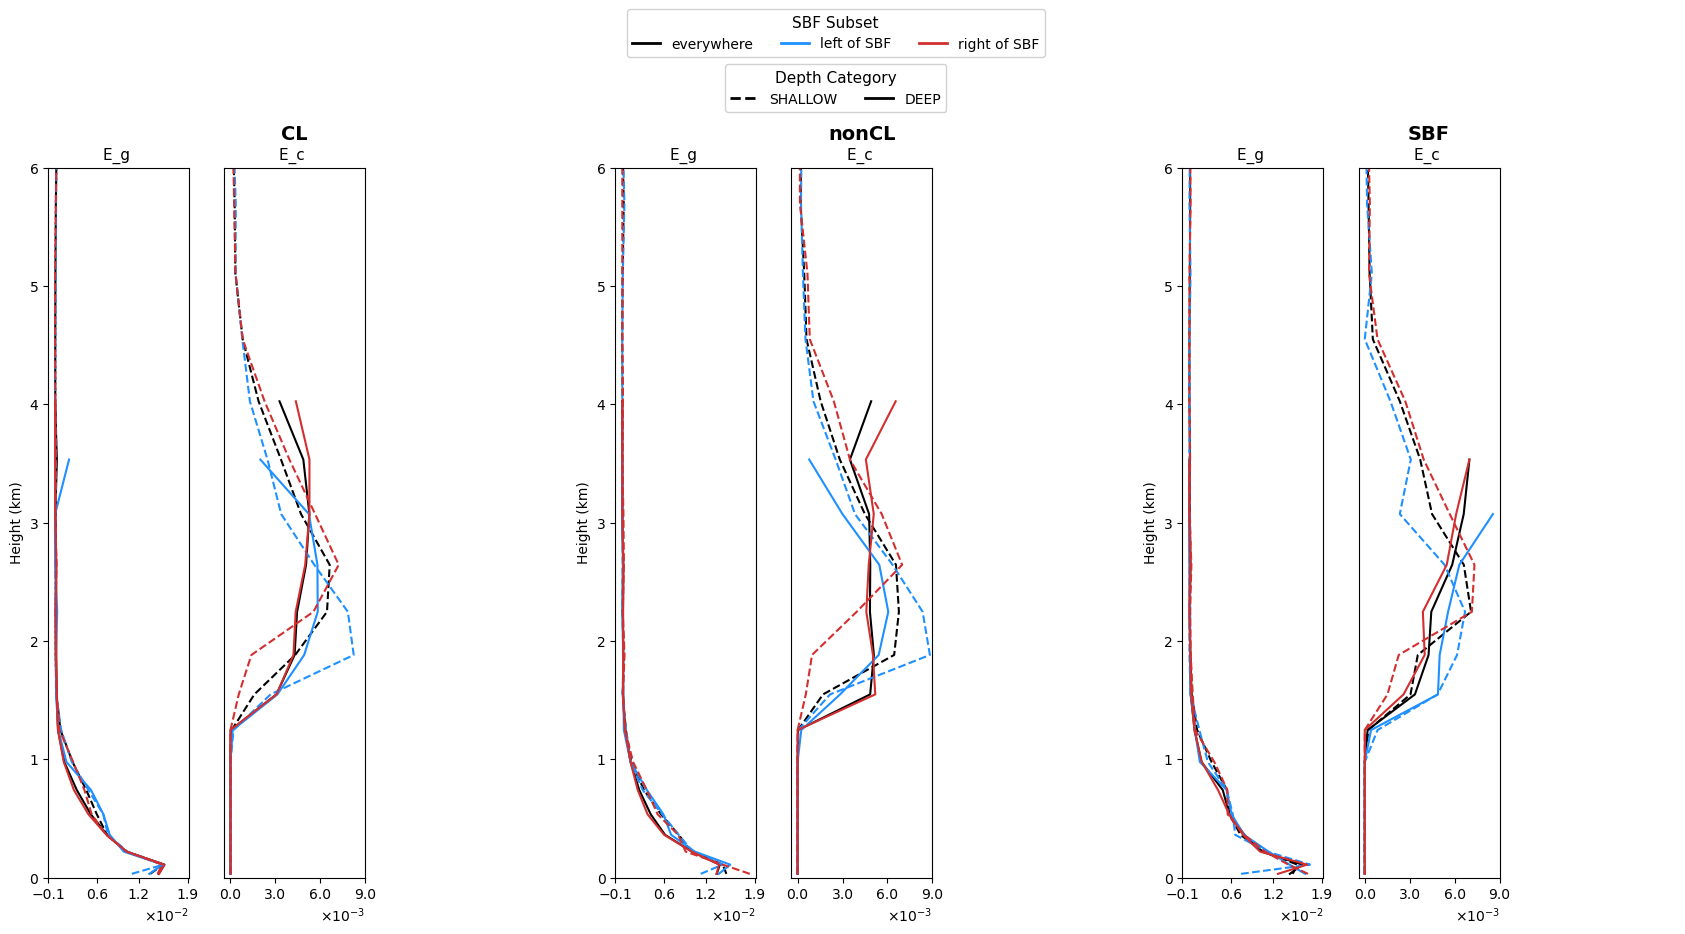

In [137]:
variableNames = [f"{Processed_string}E_g-{Processed_string}D_g", f"{Processed_string}E_c-{Processed_string}D_c",
                 f"{Processed_string}TransferE_c", f"{Processed_string}TransferE_c/{Processed_string}E_c"]

variableNames=[f"{Processed_string}E_g",f"{Processed_string}E_c"]


fig = LocationSubset_Plotting_CLASS.PlotProfiles(
    trackedProfileArrays,
    variableInfo,
    variableNames = variableNames
)
ApplyFormatting(fig, variableNames)

# #saving
# fileName=f"Tracked_Profiles_{dataName}_LocationSubset" 
# SaveFigure(fig,plotType=f"Project_Algorithms/Tracked_Profiles/Tracked_Profiles_{dataName}",fileName=fileName)